In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import re

import textstat

from collections import Counter

from bertopic import BERTopic
import gensim
from gensim import corpora
import pyLDAvis.gensim_models

from scipy.stats import iqr

from transformers import pipeline

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



# EDA - Lyrics

In [48]:
#read tracks_spotify_lang - 
#the file contains the detected language created with the get_language script
tracks_lang=pd.read_csv('data/tracks_spotify_lang.csv')

In [49]:
#Remove rows of repeating lyrics
tracks_lang_no_dup = tracks_lang.drop_duplicates(subset='lyrics', keep='first').reset_index()

#get counts of languages
tracks_lang_no_dup['language'].value_counts().head(10)


language
en    25722
es     6072
pt     1949
fr     1433
de      882
fi      754
it      741
sv      677
da      535
nl      450
Name: count, dtype: int64

In [50]:
#filter for only the english ones
filtered_df = tracks_lang_no_dup[tracks_lang_no_dup['language'].isin(['en'])]
#get number of songs
len(filtered_df)

25722

In [51]:
#lowercasing the lyrics and saving them in new column
filtered_df['lyrics_clean'] = filtered_df['lyrics'].str.lower()
#removing digits
filtered_df['lyrics_clean'] = filtered_df['lyrics_clean'].apply(lambda x: re.sub(r'\d+', '', x))
#removing punctuation
filtered_df['lyrics_clean'] = filtered_df['lyrics_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [52]:
#get a look of lyrics
filtered_df['lyrics_clean'] 

0          perhaps i am bound to be restless always yea...
1         your gods and my godsdo you or i know which a...
2          closed off from love i didnt need the pain o...
3         pain n an uncomfortable frame of mind that ma...
4         if there were an ocean wed be wading in the d...
                               ...                        
40811      black fingernails red wine i wanna make you ...
40812      i got killed by black bugs on my video game ...
40813     no more maybes your babys got rabies sitting ...
40814     walking down the street with some evil in my ...
40815     theres not enough hours in my day to tell you...
Name: lyrics_clean, Length: 25722, dtype: object

In [11]:
#extend stopwords
new_stop_words = ['aba','ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh', 'hmm','deh','doh','jah','wa','la','na','oh','em','da','dem','mi','di','fi','gyal','dey','ey','eh','inna','nuh','pon','ba','ye','de','weh','gal','oo','bam','wid','mek','seh','aah','li','ni','waan','wey']

#define a function that removes english stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(new_stop_words) 
    words = word_tokenize(text)
    return " ".join([word for word in words if word.lower() not in stop_words])

#define a funtion that tokenizes the lyrics 
def tokenize_text(text):
    return nltk.word_tokenize(str(text))

In [12]:
#apply the defined funtions
filtered_df['lyrics_clean'] = filtered_df['lyrics_clean'].apply(remove_stopwords)
filtered_df['lyrics_clean'] = filtered_df['lyrics_clean'].apply(tokenize_text)

In [13]:
#lemmatizing lyrics
lemmatizer = WordNetLemmatizer()
filtered_df['lyrics_clean'] = filtered_df['lyrics_clean'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

In [14]:
#Join list items into a single string without commas 'untokenize'
filtered_df['lyrics_clean_untok'] = filtered_df['lyrics_clean'].apply(' '.join)

# Display the result
len(filtered_df['lyrics_clean_untok'])

25722

In [15]:
#eliminate rows that contain characters outside the usual English alphabet
pattern = '^[a-zA-Z\s,.;?!-]*$'
filtered_df = filtered_df.dropna(subset=['lyrics_clean_untok'])
filtered_df = filtered_df[filtered_df['lyrics_clean_untok'].str.contains(pattern)]

<>:2: DeprecationWarning: invalid escape sequence '\s'
<>:2: DeprecationWarning: invalid escape sequence '\s'
/var/folders/60/s86dq17j5zd4vn2hf6ywd3200000gn/T/ipykernel_55140/3523277907.py:2: DeprecationWarning: invalid escape sequence '\s'
  pattern = '^[a-zA-Z\s,.;?!-]*$'


In [16]:
#get a look of lyrics
filtered_df['lyrics_clean']

0        [perhaps, bound, restless, always, yearning, n...
1        [god, godsdo, know, stronger, native, proverb,...
2        [closed, love, didnt, need, pain, twice, enoug...
3        [pain, n, uncomfortable, frame, mind, may, phy...
4        [ocean, wed, wading, distance, would, water, c...
                               ...                        
40811    [black, fingernail, red, wine, wan, make, mine...
40812    [got, killed, black, bug, video, game, go, doe...
40813    [maybes, baby, got, rabies, sitting, ball, mid...
40814    [walking, street, evil, eye, thought, head, ma...
40815    [there, enough, hour, day, tell, youre, gettin...
Name: lyrics_clean, Length: 24620, dtype: object

In [17]:
#get a look of untokenized lyrics
filtered_df['lyrics_clean_untok']

0        perhaps bound restless always yearning never s...
1        god godsdo know stronger native proverb east s...
2        closed love didnt need pain twice enough vain ...
3        pain n uncomfortable frame mind may physical b...
4        ocean wed wading distance would water creating...
                               ...                        
40811    black fingernail red wine wan make mine lot pe...
40812    got killed black bug video game go doesnt mean...
40813    maybes baby got rabies sitting ball middle and...
40814    walking street evil eye thought head making fe...
40815    there enough hour day tell youre getting way t...
Name: lyrics_clean_untok, Length: 24620, dtype: object

(0.0, 10000.0)

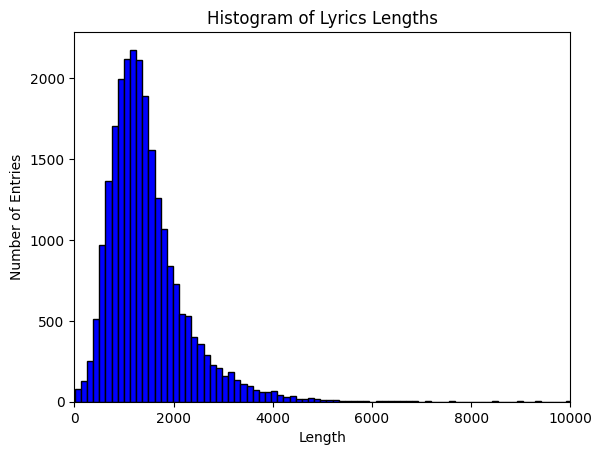

In [18]:
#creating a histogram with lyrics length, based on the original data
filtered_df['word_count']= filtered_df['lyrics'].apply(len)
plt.hist(filtered_df['word_count'], bins=1000, color='blue', edgecolor='black')
plt.title("Histogram of Lyrics Lengths")
plt.xlabel("Length")
plt.ylabel("Number of Entries")
plt.xlim(0, 10000)  # Setting limit for x-axis

(0.0, 1000.0)

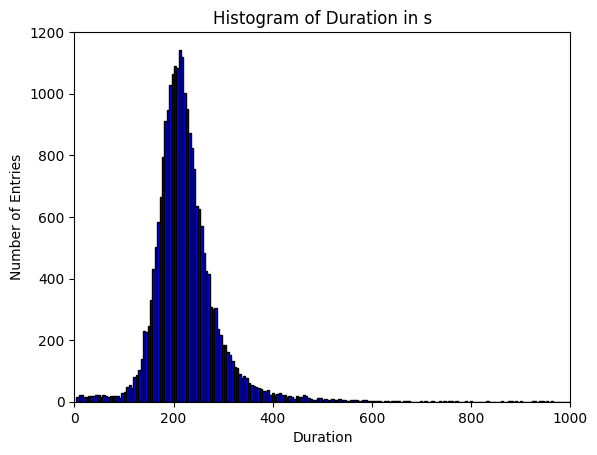

In [19]:
#creating a histogram with sock leng
# th in s, based on the original data
filtered_df['duration_s']=filtered_df['duration_ms'] / 1000

plt.hist(filtered_df['duration_s'], bins=1000, color='blue', edgecolor='black')
plt.title("Histogram of Duration in s")
plt.xlabel("Duration")
plt.ylabel("Number of Entries")
plt.xlim(0, 1000)  # Setting limit for x-axis

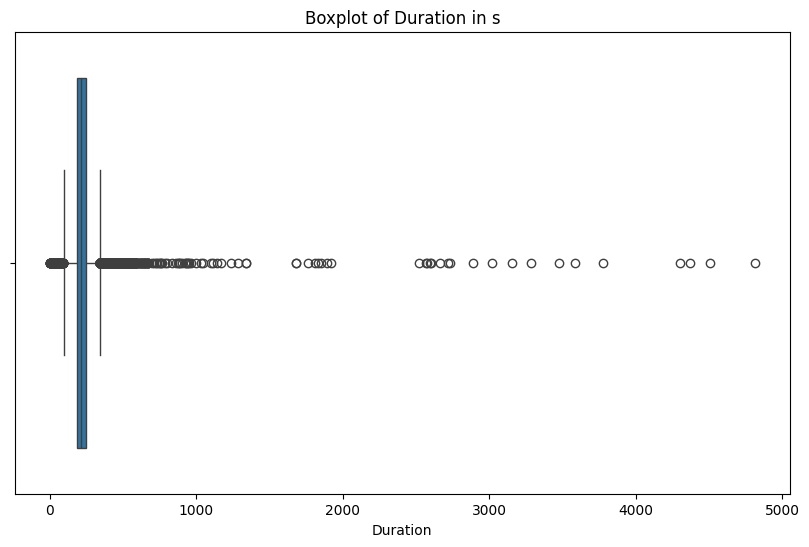

In [20]:
#create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['duration_s'])
plt.title("Boxplot of Duration in s")
plt.xlabel("Duration")
plt.show()

In [21]:
#calculate mean and median of duration
mean = np.mean(filtered_df['duration_s'])
median = np.median(filtered_df['duration_s'])

# Quartiles
q1 = np.percentile(filtered_df['duration_s'], 25)
q3 = np.percentile(filtered_df['duration_s'], 75)

# Interquartile range
iqr_value = iqr(filtered_df['duration_s'])

# Whiskers
lower_whisker = q1 - 1.5 * iqr_value
upper_whisker = q3 + 1.5 * iqr_value

print("Mean:", mean)
print("Median:", median)
print("Q1:", q1)
print("Q3:", q3)
print("IQR:", iqr_value)
print("Lower Whisker:", lower_whisker)
print("Upper Whisker:", upper_whisker)

Mean: 227.00761588139721
Median: 215.3345
Q1: 187.73975
Q3: 249.333
IQR: 61.59325000000001
Lower Whisker: 95.34987499999997
Upper Whisker: 341.72287500000004


In [22]:
#calculate mean and median of word_count
mean = np.mean(filtered_df['word_count'])
median = np.median(filtered_df['word_count'])

# Quartiles
q1 = np.percentile(filtered_df['word_count'], 25)
q3 = np.percentile(filtered_df['word_count'], 75)

# Interquartile range
iqr_value = iqr(filtered_df['word_count'])

# Whiskers
lower_whisker = q1 - 1.5 * iqr_value
upper_whisker = q3 + 1.5 * iqr_value

print("Mean:", mean)
print("Median:", median)
print("Q1:", q1)
print("Q3:", q3)
print("IQR:", iqr_value)
print("Lower Whisker:", lower_whisker)
print("Upper Whisker:", upper_whisker)

Mean: 1563.0395613322503
Median: 1301.0
Q1: 943.0
Q3: 1774.25
IQR: 831.25
Lower Whisker: -303.875
Upper Whisker: 3021.125


In [23]:
#filter the data based on duration and word count
filtered_df_short= filtered_df[(filtered_df['duration_s'] >= 90) & (filtered_df['duration_s'] <= 600)]
filtered_df_short= filtered_df_short[(filtered_df_short['word_count'] >= 500) & (filtered_df_short['word_count'] <= 6000)]

(0.0, 1000.0)

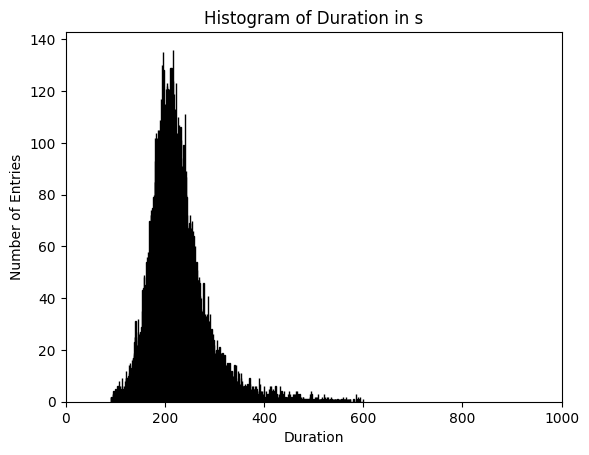

In [24]:
#creating a new histogram with length in s, based on the original data

plt.hist(filtered_df_short['duration_s'], bins=1000, color='blue', edgecolor='black')
plt.title("Histogram of Duration in s")
plt.xlabel("Duration")
plt.ylabel("Number of Entries")
plt.xlim(0, 1000)  # Setting limit for x-axis

(0.0, 15000.0)

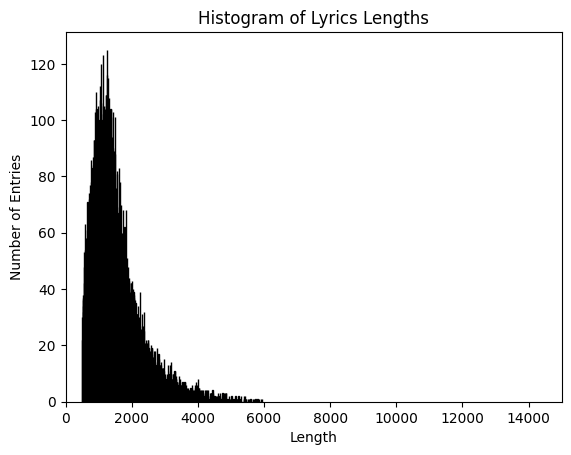

In [25]:
#creating a new histogram with lyrics length
plt.hist(filtered_df_short['word_count'], bins=1000, color='blue', edgecolor='black')
plt.title("Histogram of Lyrics Lengths")
plt.xlabel("Length")
plt.ylabel("Number of Entries")
plt.xlim(0, 15000)  # Setting limit for x-axis

In [26]:
# Flatten the list and count occurrences of each word
all_words = [word for sublist in filtered_df_short['lyrics_clean']  for word in sublist]
word_frequencies = Counter(all_words)

#get 20 most common words
common_words = word_frequencies.most_common(20)
common_words

[('im', 75672),
 ('dont', 54432),
 ('know', 50673),
 ('like', 48588),
 ('love', 48295),
 ('got', 41224),
 ('go', 31260),
 ('get', 30781),
 ('youre', 27871),
 ('let', 26223),
 ('time', 25432),
 ('one', 23721),
 ('want', 23227),
 ('baby', 22802),
 ('never', 22767),
 ('cant', 22178),
 ('see', 21437),
 ('come', 21215),
 ('feel', 21066),
 ('make', 20861)]

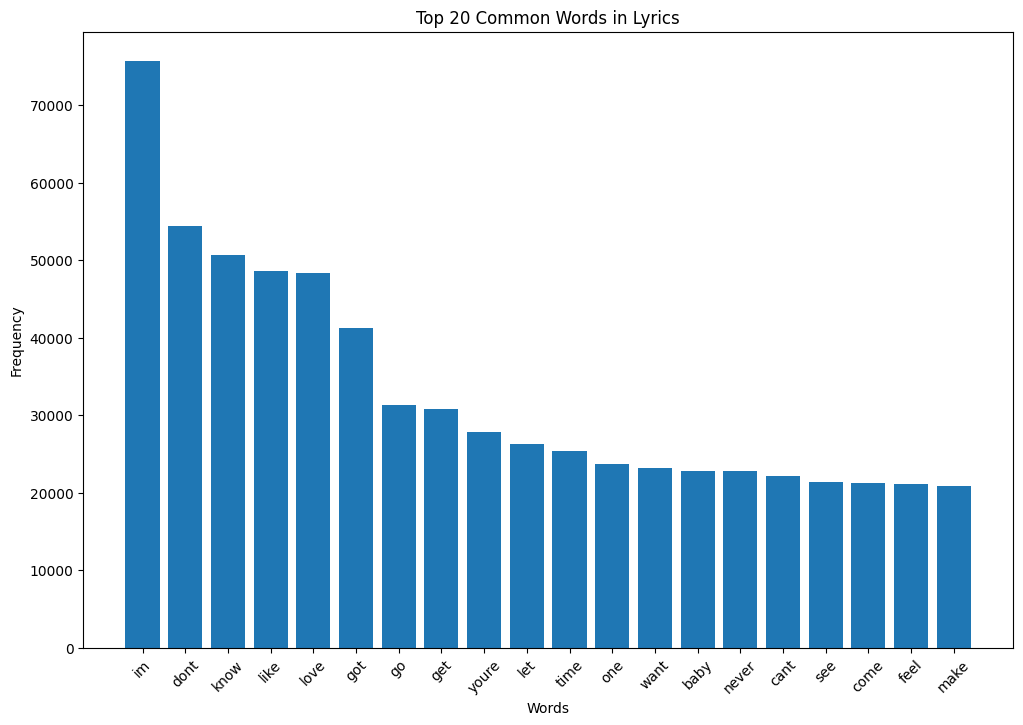

In [27]:
# Visualizing the most common words
common_words = word_frequencies.most_common(20)
labels, values = zip(*common_words)

plt.figure(figsize=(12, 8))
plt.bar(labels, values)
plt.title('Top 20 Common Words in Lyrics')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is depr

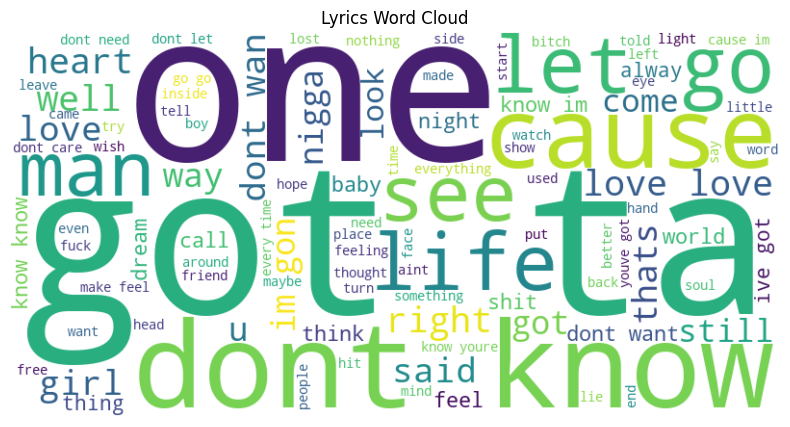

In [28]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(' '.join(all_words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Lyrics Word Cloud')
plt.show()

/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROT

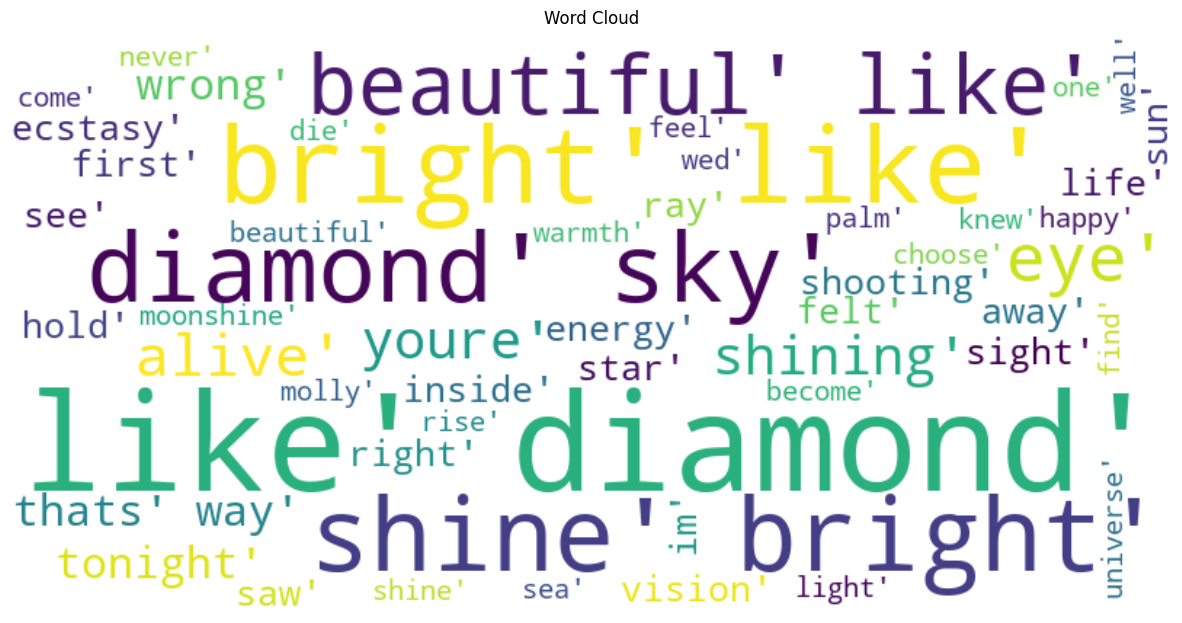

In [29]:
#filtering for diamonds by Rihanna
diamonds= filtered_df_short[filtered_df_short['id'] == '0RKqylCDwg0Lzq8Stu266U'] ['lyrics_clean']
diamonds=diamonds.iloc[0]

#creating wordcloud
wordcloud = WordCloud(width = 800, height = 400, 
                      random_state=21, max_font_size=110, 
                      background_color='white').generate(str(diamonds))

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [30]:
#define function that calculates readability metrics
def calculate_readability_metrics(text):
    try:
        ari = textstat.automated_readability_index(text)
        fre = textstat.flesch_reading_ease(text)
        fkgl = textstat.flesch_kincaid_grade(text)
        gfi = textstat.gunning_fog(text)
    except:
        ari, fre, fkgl, gfi = [None]*4  
    
    return pd.Series((ari, fre, fkgl, gfi))

filtered_df_short['lyrics_str'] = filtered_df_short['lyrics'].astype(str)
filtered_df_short[['ARI', 'FRE', 'FKGL', 'GFI']] = filtered_df_short['lyrics_str'].apply(calculate_readability_metrics)

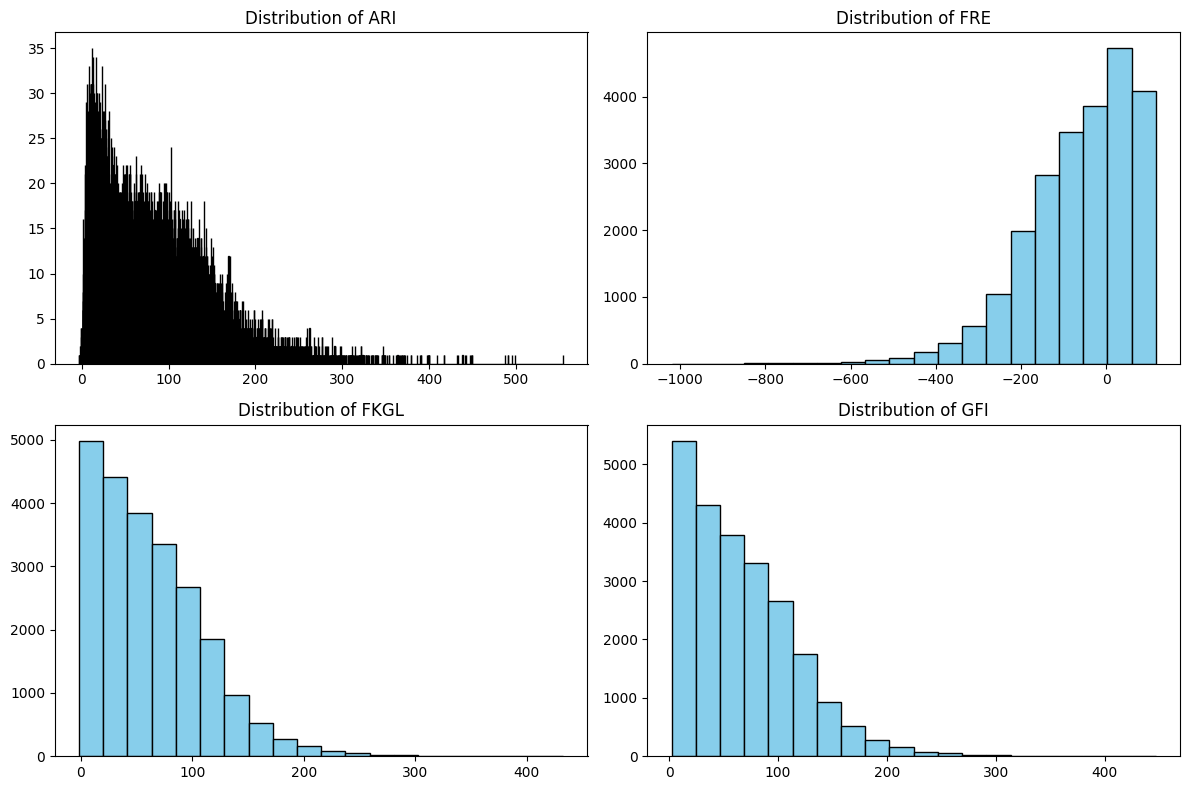

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histogram of ARI
axs[0, 0].hist(filtered_df_short['ARI'].dropna(), bins=20000, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of ARI')

# Histogram of FRE
axs[0, 1].hist(filtered_df_short['FRE'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of FRE')

# Histogram of FKGL
axs[1, 0].hist(filtered_df_short['FKGL'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of FKGL')

# Histogram of GFI
axs[1, 1].hist(filtered_df_short['GFI'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Distribution of GFI')

plt.tight_layout()
plt.show()

In [34]:
# Tokenize the text into words
words = [lyrics for sentence in filtered_df_short['lyrics'] for lyrics in nltk.word_tokenize(sentence)]

# Number of documents
num_documents = len(filtered_df_short)

# Total number of words in the corpus
total_words = len(words)

# Average document length (in words)
avg_doc_length = total_words / num_documents

# Minimum and maximum document length (in words)
min_doc_length = min(len(nltk.word_tokenize(lyrics)) for lyrics in filtered_df_short['lyrics'])
max_doc_length = max(len(nltk.word_tokenize(lyrics)) for lyrics in filtered_df_short['lyrics'])

# Vocabulary size (unique words)
vocabulary_size = len(set(words))

# Most common words and their frequencies
from collections import Counter
word_frequencies = Counter(words)
most_common_words = word_frequencies.most_common(5)

# Stopword removal
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Average sentence length (in words)
sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in filtered_df_short['lyrics']]
avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)

# Print the statistics
print(f"Number of Documents: {num_documents}")
print(f"Total Number of Words: {total_words}")
print(f"Average Document Length: {avg_doc_length:.2f} words")
print(f"Minimum Document Length: {min_doc_length} words")
print(f"Maximum Document Length: {max_doc_length} words")
print(f"Vocabulary Size: {vocabulary_size} unique words")
print(f"Filtered Words after Stopword Removal: {len(filtered_words)} words")
print(f"Average Sentence Length: {avg_sentence_length:.2f} words")

Number of Documents: 23265
Total Number of Words: 8164428
Average Document Length: 350.93 words
Minimum Document Length: 80 words
Maximum Document Length: 1582 words
Vocabulary Size: 84558 unique words
Filtered Words after Stopword Removal: 4590429 words
Average Sentence Length: 350.93 words


# Topic Modelling

## BERTopic

In [35]:
#filter only the necessary columns for further tasks
tm_df=filtered_df_short[['name','lyrics_clean','lyrics_clean_untok','word_count','duration_s','lyrics','acousticness', 'danceability', 'energy','instrumentalness', 
       'liveness', 'loudness', 'mode',
       'popularity','speechiness', 'tempo', 'valence']]

The lyrics are already preprocessed. In the part above we have removed '\r\n' (happened in 1_Get_Langauge_Translation.ipynb), digits, punctuation and stopwords. We've also lowercased tokenized and lemmatized the lyrics.

In [39]:
# Initiate BERTopic with max. number of topics10, minimal topic_size=3 
topic_model = BERTopic(nr_topics=10,min_topic_size=3,calculate_probabilities=True,language='english')
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(tm_df['lyrics_clean_untok'])

/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [40]:
#get info on topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13481,-1_im_dont_know_like,"[im, dont, know, like, love, got, go, get, you...",[drew line say one way me two way thing feel s...
1,0,9719,0_im_dont_love_know,"[im, dont, love, know, like, got, go, get, you...",[wan youre alone keep waiting hope hasnt gone ...
2,1,30,1_christmas_grandma_happy_santa,"[christmas, grandma, happy, santa, hand, holid...",[room end toy tree light present snow bing fir...
3,2,8,2_bang_zombie_head_shot,"[bang, zombie, head, shot, awful, zombieieie, ...",[five six rode horse made stick wore black wor...
4,3,7,3_right_who_gon_drive,"[right, who, gon, drive, kick, wrong, jam, fat...",[who gon tell late who gon tell thing arent gr...
5,4,5,4_electric_shock_transformer_nrg,"[electric, shock, transformer, nrg, eel, elect...",[along western front people line receive got p...
6,5,5,5_sailor_hay_morning_drunken,"[sailor, hay, morning, drunken, rise, start, b...",[met man sailor man island tan mexico sitting ...
7,6,4,6_thou_art_great_thee,"[thou, art, great, thee, sings, savior, god, s...",[lord god awesome wonder consider world thy ha...
8,7,3,7_whats_first_going_scared,"[whats, first, going, scared, courageous, dino...",[there need fear darling love youre alone ill ...
9,8,3,8_chance_another_tonight_id,"[chance, another, tonight, id, try, right, thi...",[gone begin gone weekend lie like dont need fe...


In [41]:
#print the representation info about the topics 
representations = topic_model.get_topic_info()['Representation']

for i, representation in representations.items():
    print(f"Topic {i}: {representation}")

Topic 0: ['im', 'dont', 'know', 'like', 'love', 'got', 'go', 'get', 'youre', 'time']
Topic 1: ['im', 'dont', 'love', 'know', 'like', 'got', 'go', 'get', 'youre', 'let']
Topic 2: ['christmas', 'grandma', 'happy', 'santa', 'hand', 'holiday', 'stole', 'baby', 'orleans', 'sock']
Topic 3: ['bang', 'zombie', 'head', 'shot', 'awful', 'zombieieie', 'bomb', 'whats', 'ground', 'hit']
Topic 4: ['right', 'who', 'gon', 'drive', 'kick', 'wrong', 'jam', 'fatboy', 'cant', 'home']
Topic 5: ['electric', 'shock', 'transformer', 'nrg', 'eel', 'electricity', 'girl', 'feel', 'man', 'said']
Topic 6: ['sailor', 'hay', 'morning', 'drunken', 'rise', 'start', 'brandy', 'early', 'earleye', 'drink']
Topic 7: ['thou', 'art', 'great', 'thee', 'sings', 'savior', 'god', 'soul', 'shall', 'thy']
Topic 8: ['whats', 'first', 'going', 'scared', 'courageous', 'dinosaur', 'brave', 'ive', 'see', 'wasnt']
Topic 9: ['chance', 'another', 'tonight', 'id', 'try', 'right', 'thing', 'tell', 'soon', 'got']


In [43]:
#create barcharts
topic_model.visualize_barchart(top_n_topics=15,n_words=9)

In [42]:
#visualize the topic distances
topic_model.visualize_topics()

/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/Users/tomtom_ghost/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.



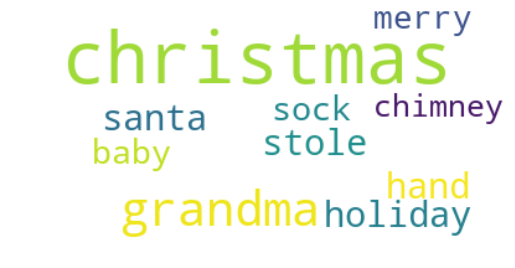

In [41]:
#function that creates wordclouds ouf of the words in topics
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Show word cloud
create_wordcloud(topic_model, topic=2)

## LDA

In [54]:
tm_df['lyrics_clean']

0        [perhaps, bound, restless, always, yearning, n...
2        [closed, love, didnt, need, pain, twice, enoug...
4        [ocean, wed, wading, distance, would, water, c...
6        [picture, mind, world, devised, wrote, read, n...
7        [youre, beauty, stranger, grocery, store, your...
                               ...                        
40811    [black, fingernail, red, wine, wan, make, mine...
40812    [got, killed, black, bug, video, game, go, doe...
40813    [maybes, baby, got, rabies, sitting, ball, mid...
40814    [walking, street, evil, eye, thought, head, ma...
40815    [there, enough, hour, day, tell, youre, gettin...
Name: lyrics_clean, Length: 23265, dtype: object

In [36]:
texts=tm_df['lyrics_clean']

# Create a dictionary and corpus
# map each unique word in the texts to a unique integer ID
dictionary = corpora.Dictionary(texts)
# create boW represantation 
corpus = [dictionary.doc2bow(text) for text in texts]

In [37]:
#initiate lda_model
lda_model = gensim.models.LdaModel(corpus, num_topics=6, id2word=dictionary, passes=30)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.095*"go" + 0.069*"let" + 0.055*"wan" + 0.033*"ya" + 0.027*"ah" + 0.021*"run" + 0.021*"got" + 0.020*"ta" + 0.015*"body" + 0.013*"want"')
(1, '0.040*"im" + 0.030*"dont" + 0.027*"know" + 0.015*"youre" + 0.014*"time" + 0.013*"cant" + 0.012*"never" + 0.010*"say" + 0.010*"cause" + 0.010*"like"')
(2, '0.096*"love" + 0.041*"baby" + 0.026*"want" + 0.021*"like" + 0.020*"feel" + 0.019*"need" + 0.019*"know" + 0.017*"make" + 0.017*"dont" + 0.016*"give"')
(3, '0.020*"get" + 0.020*"like" + 0.016*"come" + 0.012*"night" + 0.012*"girl" + 0.011*"man" + 0.011*"back" + 0.010*"dance" + 0.010*"shes" + 0.010*"right"')
(4, '0.025*"im" + 0.023*"like" + 0.022*"got" + 0.014*"aint" + 0.014*"nigga" + 0.012*"get" + 0.011*"bitch" + 0.010*"dont" + 0.009*"fuck" + 0.009*"shit"')
(5, '0.010*"life" + 0.010*"light" + 0.009*"see" + 0.008*"heart" + 0.008*"eye" + 0.008*"world" + 0.008*"u" + 0.007*"come" + 0.007*"away" + 0.007*"god"')


In [38]:
#visualize results
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

## Zero Shot Topic Modeling

In [235]:
#set up pipeline for zero_shot_classification
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [44]:
#get most popular songs
zs_df=tm_df.sort_values(by='popularity', ascending=False).head(50)


In [282]:
candidate_labels = ['breakup', 'desire', 'pain','inspiration','party']
classifier(sequence_to_classify, candidate_labels)

#function for classification
def classify_sequence(sequence):
    result = classifier(sequence, candidate_labels)
    label = result['labels'][0]
    score = result['scores'][0]
    return label, score
#write results back to df
zs_df['label'], zs_df['score'] = zip(*zs_df['lyrics'].apply(classify_sequence))

In [46]:
#look at first ten results
zs_df.sort_values(by='score', ascending=False).head(10)



KeyError: 'score'

## Sentiment Analysis

In [58]:
#use TextBlob for sentiment analysis
lyrics = "I am sad"
blob = TextBlob(lyrics)
sentiment = blob.sentiment.polarity

sentiment

-0.5

In [220]:
#function to get the sentiment value
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment
#function to get the wording
def sentiment_wording(value):
    if value > 0:
        return "Positive Sentiment"
    elif value < 0:
        return "Negative Sentiment"
    else:
        return "Neutral Sentiment"

# Apply functions to dataframe
tm_df['sentiment_value_textblob'] = tm_df['lyrics'].apply(get_sentiment)
tm_df['sentiment_wording_textblob'] = tm_df['sentiment_value_textblob'].apply(sentiment_wording)

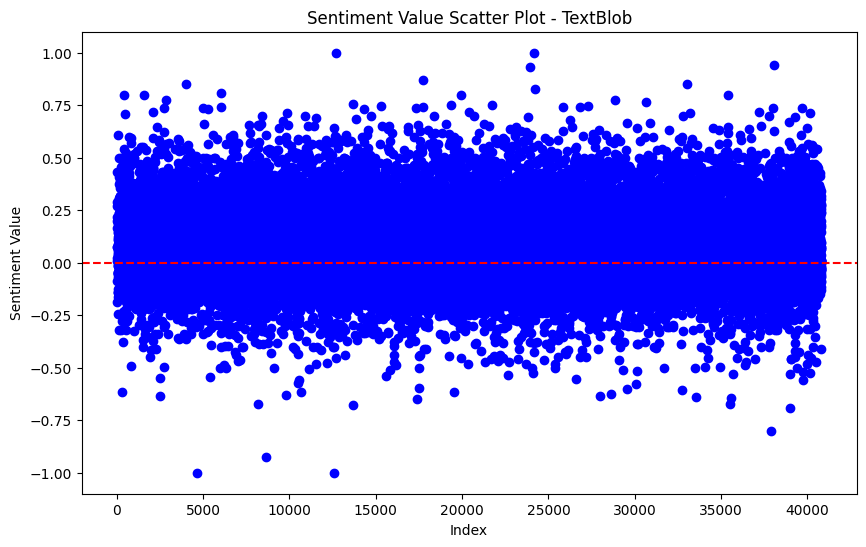

In [223]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(tm_df.index, tm_df['sentiment_value_textblob'], color='blue')
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.title('Sentiment Value Scatter Plot - TextBlob')
plt.xlabel('Index')
plt.ylabel('Sentiment Value')
plt.show()

In [66]:
#use TextBlob for sentiment analysis
text='I am nice but I am also stupid'
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(text)

{'neg': 0.368, 'neu': 0.48, 'pos': 0.152, 'compound': -0.5719}

In [242]:
#initialize vader analyzer
analyzer = SentimentIntensityAnalyzer()

#get sentiment score
def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

#get wording for score
def sentiment_wording(value):
    if value > 0.5:
        return "Positive Sentiment"
    elif value < -0.5:
        return "Negative Sentiment"
    else:
        return "Neutral Sentiment"

# Apply functions to dataframe
tm_df['sentiment_value_vader'] = tm_df['lyrics'].apply(get_sentiment)
tm_df['sentiment_wording_vader'] = tm_df['sentiment_value_vader'].apply(sentiment_wording)


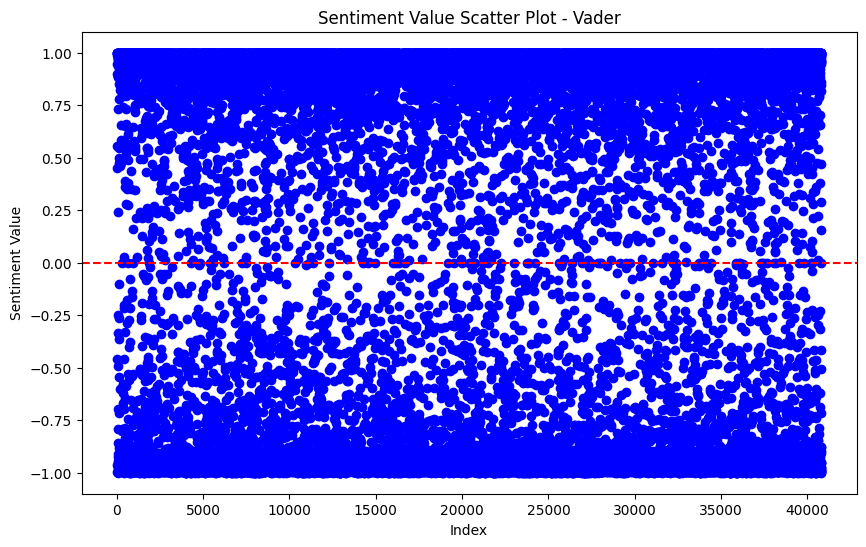

In [243]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(tm_df.index, tm_df['sentiment_value_vader'], color='blue')
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.title('Sentiment Value Scatter Plot - Vader')
plt.xlabel('Index')
plt.ylabel('Sentiment Value')
plt.show()

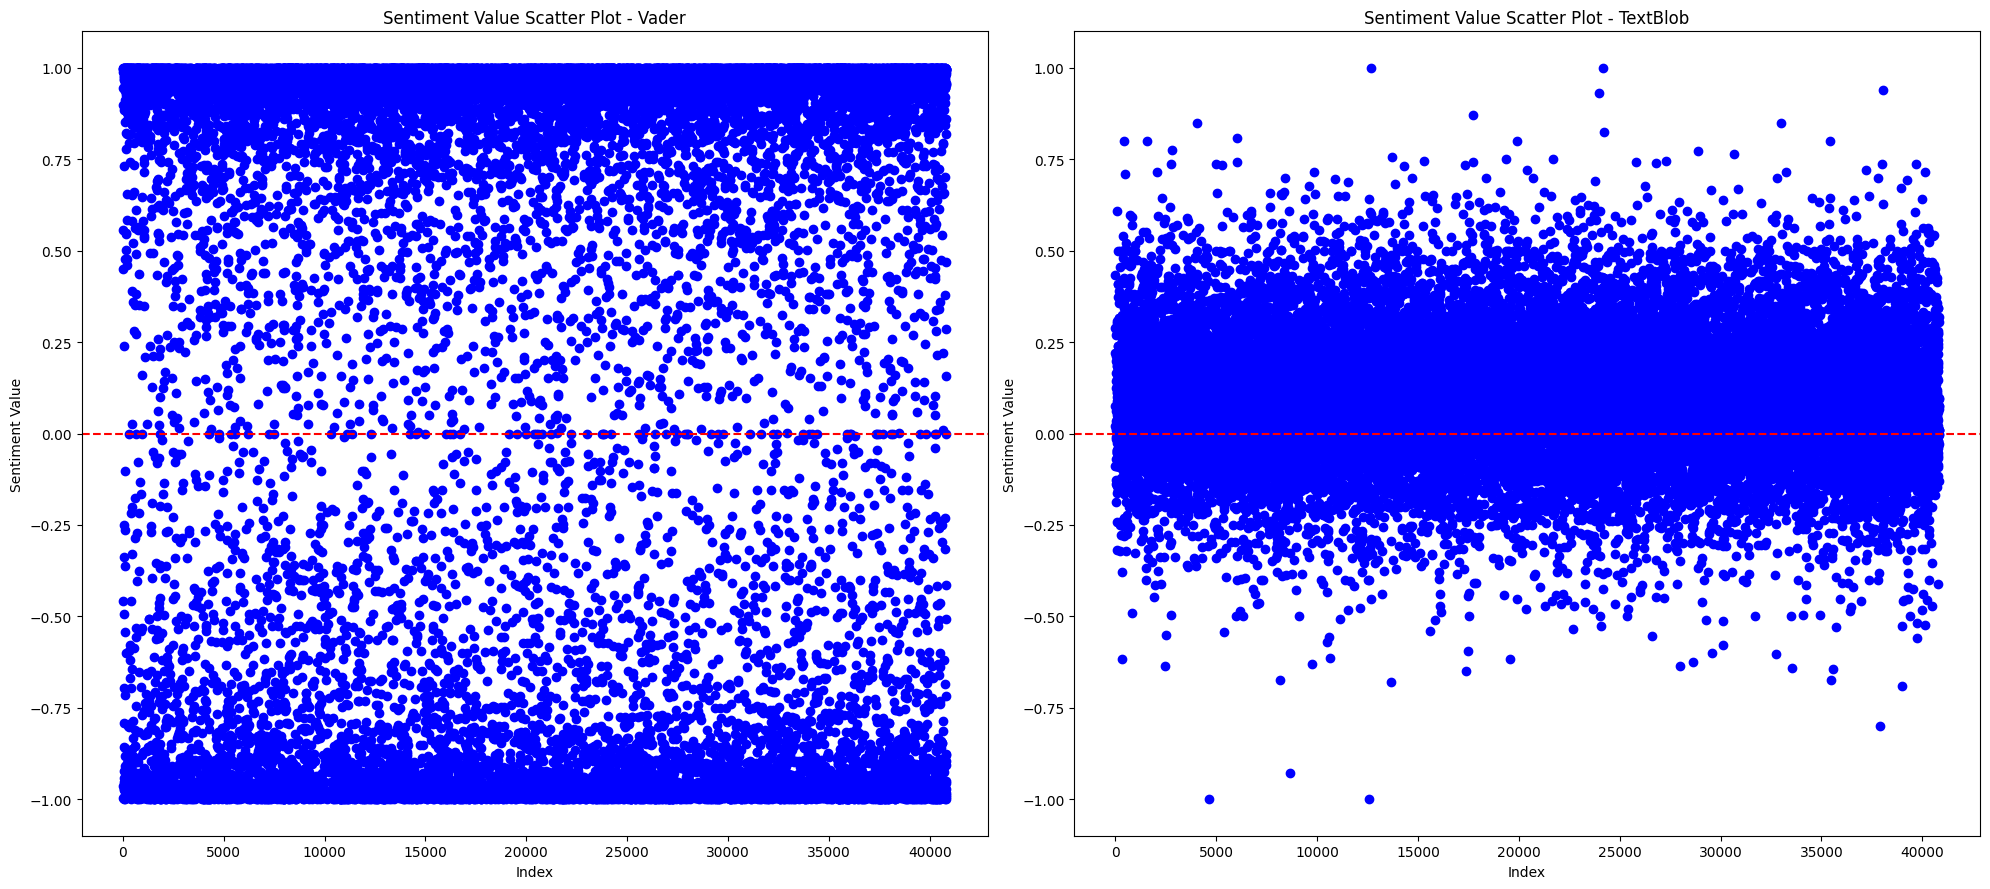

In [240]:
#compare both methods
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

# Plot for Vader
axes[0].scatter(tm_df.index, tm_df['sentiment_value_vader'], color='blue')
axes[0].axhline(0, color='red', linestyle='--') 
axes[0].set_title('Sentiment Value Scatter Plot - Vader')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Sentiment Value')

# Plot for TextBlob
axes[1].scatter(tm_df.index, tm_df['sentiment_value_textblob'], color='blue')
axes[1].axhline(0, color='red', linestyle='--') 
axes[1].set_title('Sentiment Value Scatter Plot - TextBlob')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Sentiment Value')

plt.tight_layout()
plt.show()

In [67]:
#standardize values
scaler = MinMaxScaler()
tm_df['sentiment_value_vader_stand'] = scaler.fit_transform(tm_df[['sentiment_value_vader']])
tm_df['sentiment_value_textblob_stand'] = scaler.fit_transform(tm_df[['sentiment_value_textblob']])
tm_df['popularity_stand'] = scaler.fit_transform(tm_df[['popularity']])


KeyError: "None of [Index(['sentiment_value_vader'], dtype='object')] are in the [columns]"

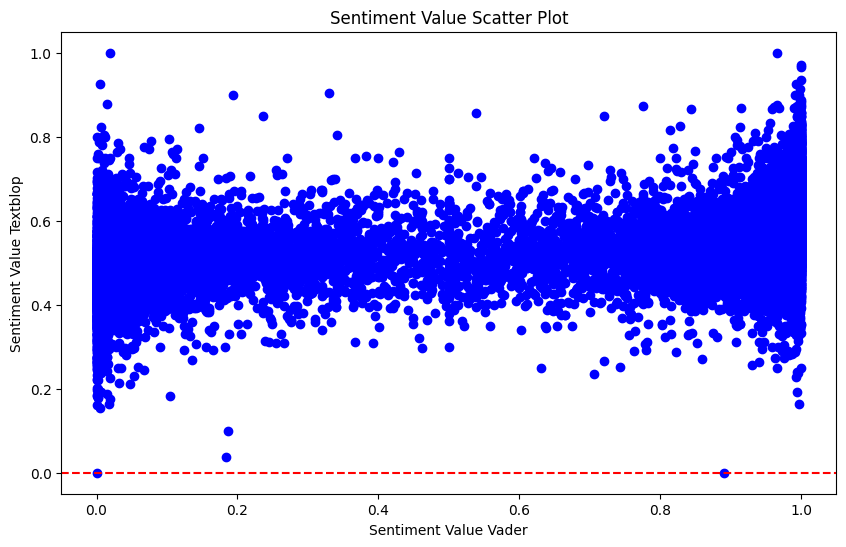

0.43660627223510423


In [205]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(tm_df['sentiment_value_vader_stand'], tm_df['sentiment_value_textblob_stand'], color='blue')
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.title('Sentiment Value Scatter Plot')
plt.xlabel('Sentiment Value Vader')
plt.ylabel('Sentiment Value Textblop')
plt.show()

#calculate correlation_coefficient
correlation_coefficient = tm_df['sentiment_value_vader_stand'].corr(tm_df['sentiment_value_textblob_stand'])
print(correlation_coefficient)

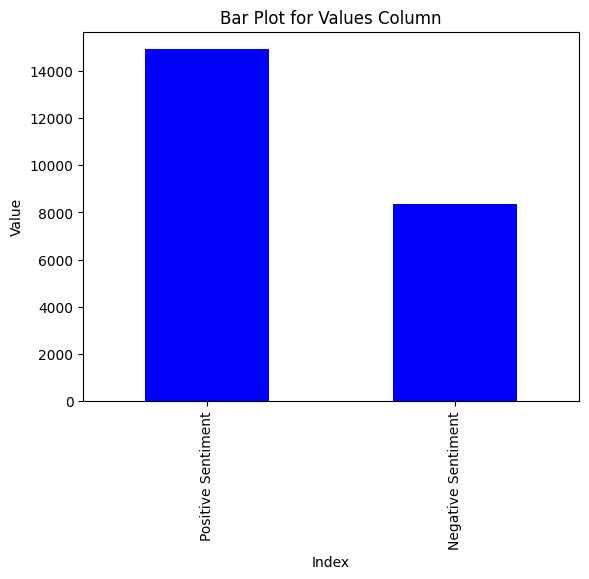

In [237]:
#create barplot for VADER
category_counts = tm_df['sentiment_wording_vader'].value_counts()

category_counts.plot(kind='bar', color='blue')

# Set title and labels
plt.title('Bar Plot for Values Column')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

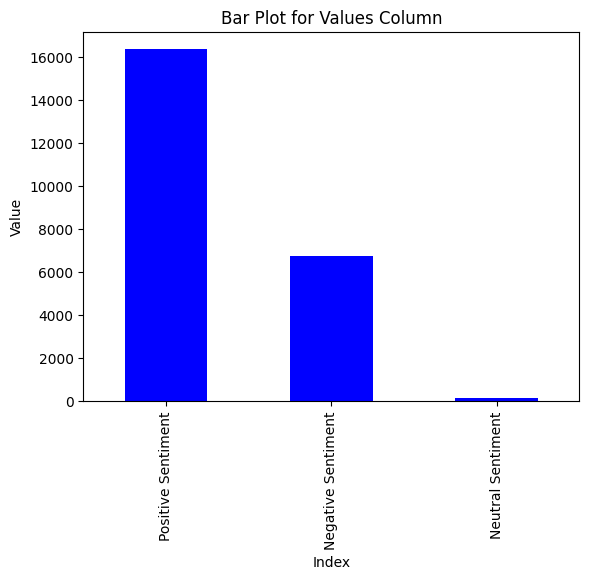

In [234]:
#create barplot for textblob
category_counts = tm_df['sentiment_wording_textblob'].value_counts()

category_counts.plot(kind='bar', color='blue')

# Set title and labels
plt.title('Bar Plot for Values Column')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

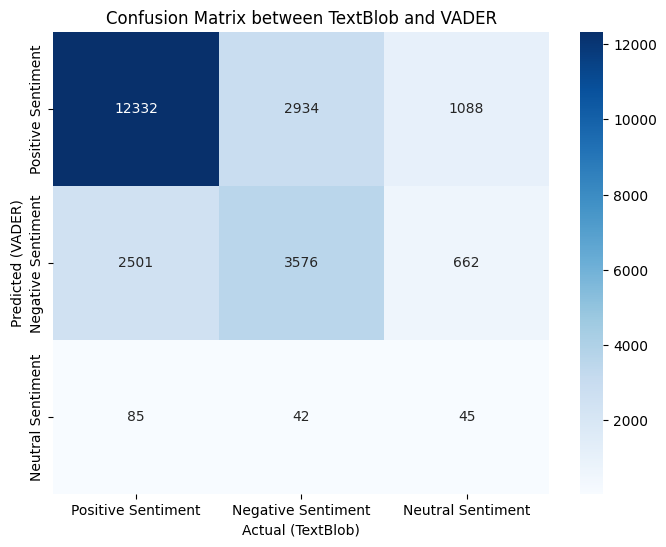

In [244]:
# List of labels in the order you want them to appear in the confusion matrix
labels = ['Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment']

# Compute the confusion matrix
cm = confusion_matrix(tm_df['sentiment_wording_textblob'], tm_df['sentiment_wording_vader'], labels=labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Actual (TextBlob)')
plt.ylabel('Predicted (VADER)')
plt.title('Confusion Matrix between TextBlob and VADER')
plt.show()

In [245]:
labels = ['Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment']

# Compute the metrics
report = classification_report(tm_df['sentiment_wording_textblob'], tm_df['sentiment_wording_vader'], labels=labels)

print(report)

                    precision    recall  f1-score   support

Positive Sentiment       0.83      0.75      0.79     16354
Negative Sentiment       0.55      0.53      0.54      6739
 Neutral Sentiment       0.03      0.26      0.05       172

          accuracy                           0.69     23265
         macro avg       0.47      0.52      0.46     23265
      weighted avg       0.74      0.69      0.71     23265



In [239]:
#compute accuracy
accuracy = accuracy_score(tm_df['sentiment_wording_textblob'], tm_df['sentiment_wording_vader'])
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


In [68]:
# Scatter plot of sentiment values textblob standardized and energy
plt.figure(figsize=(10,6))
plt.scatter(tm_df['sentiment_value_textblob_stand'], tm_df['energy'], color='blue')
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.title('Sentiment Value Scatter Plot')
plt.xlabel('Sentiment Value Vader')
plt.ylabel('Sentiment Value Textblop')
plt.show()

KeyError: 'sentiment_value_textblob_stand'

<Figure size 1000x600 with 0 Axes>

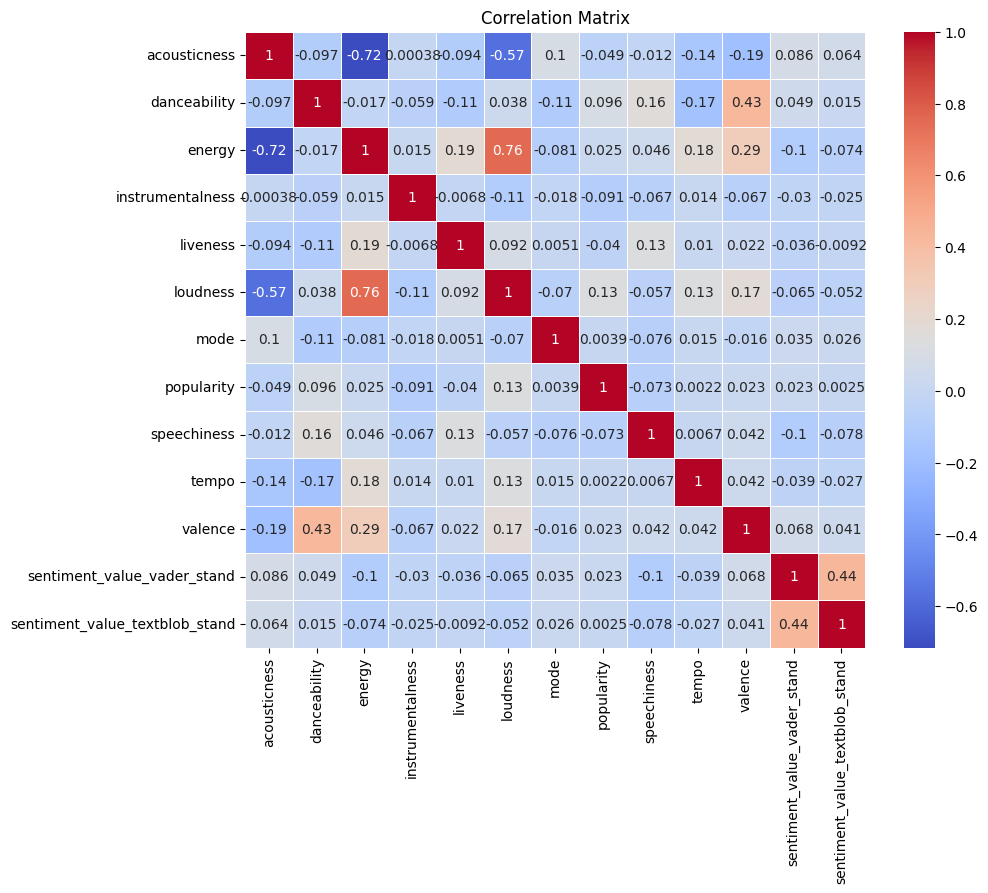

In [211]:
#create correlation matrix
correlation_matrix= tm_df[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'mode','popularity',
'speechiness', 'tempo', 'valence','sentiment_value_vader_stand','sentiment_value_textblob_stand']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()